## Uisng Logistic Regression, what factors are significant predictors of fatal migration incidents?

### Data Loading and Initial Inspection


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

# Load the Excel file
file_path = r"C:\Users\Sietoyo\Downloads\Missing_Migrants_Global_Figures_allData.xlsx"
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
print(df.head())

# Get basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())


         Main ID    Incident ID Incident Type Region of Incident  \
0  2014.MMP00001  2014.MMP00001      Incident      North America   
1  2014.MMP00002  2014.MMP00002      Incident      North America   
2  2014.MMP00003  2014.MMP00003      Incident      North America   
3  2014.MMP00004  2014.MMP00004      Incident      North America   
4  2014.MMP00005  2014.MMP00005      Incident             Europe   

  Incident Date  Incident Year    Month  Number of Dead  \
0    2014-01-06           2014  January             1.0   
1    2014-01-12           2014  January             1.0   
2    2014-01-14           2014  January             1.0   
3    2014-01-16           2014  January             1.0   
4    2014-01-16           2014  January             1.0   

   Minimum Estimated Number of Missing  Total Number of Dead and Missing  ...  \
0                                  NaN                                 1  ...   
1                                  NaN                                 1  

### Data Cleaning and Preprocessing


In [3]:
# Fill missing values for numerical columns with median
num_cols = ['Number of Dead', 'Minimum Estimated Number of Missing', 'Number of Survivors', 
            'Number of Females', 'Number of Males', 'Number of Children']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Verify that missing values have been filled
print(df.isnull().sum())



Main ID                                   0
Incident ID                               0
Incident Type                             0
Region of Incident                        0
Incident Date                            15
Incident Year                             0
Month                                     0
Number of Dead                            0
Minimum Estimated Number of Missing       0
Total Number of Dead and Missing          0
Number of Survivors                       0
Number of Females                         0
Number of Males                           0
Number of Children                        0
Country of Origin                         0
Region of Origin                          1
Cause of Death                            0
Country of Incident                       0
Migration Route                        2546
Location of Incident                      0
Coordinates                               1
UNSD Geographical Grouping                1
Information Source              

In [5]:
# Drop blank or NaN values in "Country of Origin" 
df['Country of Origin'] = df['Country of Origin'].dropna




### Feature Engineering


In [6]:
# Create the binary outcome variable 'Fatal' (1 if Number of Dead > 0, else 0)
df['Fatal'] = df['Number of Dead'] > 0
df['Fatal'] = df['Fatal'].astype(int)

# Verify the 'Fatal' column
print(df['Fatal'].value_counts())


1    16688
0       11
Name: Fatal, dtype: int64


### Exploratory Data Analysis (EDA)

North America         3313
Southern Asia         3126
Mediterranean         2585
Northern Africa       2210
Central America       1803
Western Africa        1054
Europe                 731
Eastern Africa         560
Western Asia           514
South-eastern Asia     269
South America          235
Caribbean              192
Middle Africa           75
Southern Africa         16
Eastern Asia            15
Central Asia             1
Name: Region of Incident, dtype: int64
Drowning                                                                  4179
Mixed or unknown                                                          3624
Vehicle accident / death linked to hazardous transport                    2790
Sickness / lack of access to adequate healthcare                          1869
Harsh environmental conditions / lack of adequate shelter, food, water    1795
Violence                                                                  1694
Accidental death                                       

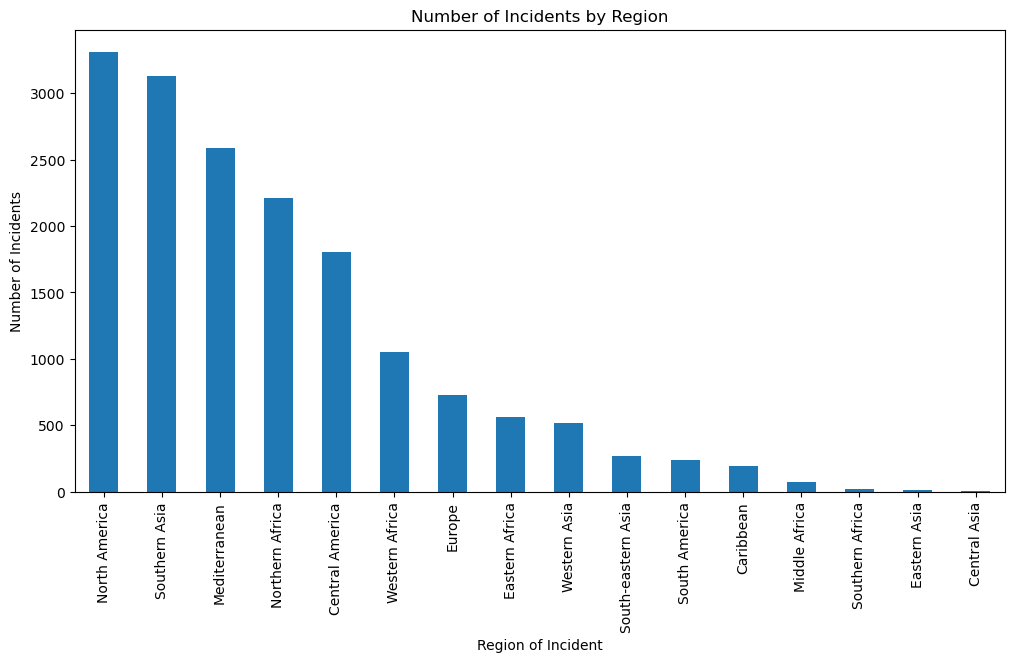

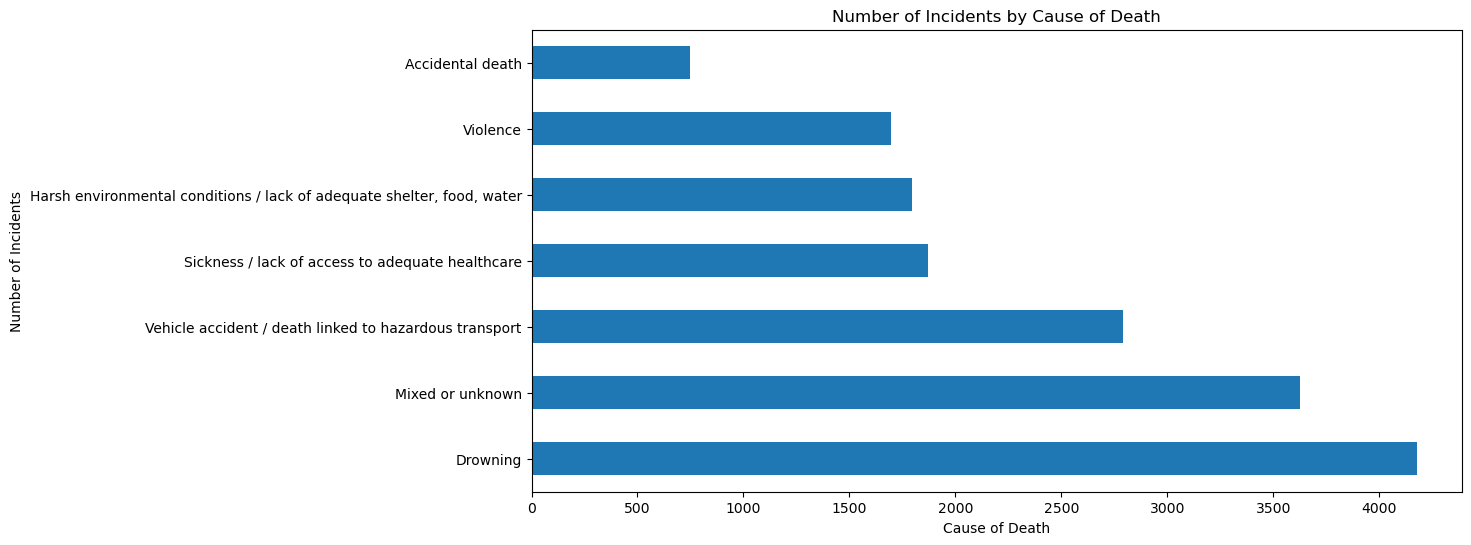

In [7]:
# Group by Region of Incident and count the number of incidents
region_incidents = df['Region of Incident'].value_counts().sort_values(ascending=False)
print(region_incidents)

# Group by Cause of Death and count the number of incidents
cause_of_death = df['Cause of Death'].value_counts().sort_values(ascending=False)
print(cause_of_death)

# Calculate the total number of dead and missing by region
dead_missing_by_region = df.groupby('Region of Incident')['Total Number of Dead and Missing'].sum().sort_values(ascending=False)
print(dead_missing_by_region)

# Plot incidents by region
plt.figure(figsize=(12, 6))
region_incidents.plot(kind='bar', title='Number of Incidents by Region')
plt.xlabel('Region of Incident')
plt.ylabel('Number of Incidents')
plt.show()

# Plot cause of death
plt.figure(figsize=(12, 6))
cause_of_death.plot(kind='barh', title='Number of Incidents by Cause of Death')
plt.xlabel('Cause of Death')
plt.ylabel('Number of Incidents')
plt.show()


### Data Preparation for Modeling


In [9]:
# Prepare the data for modeling
categorical_cols = ['Region of Incident', 'Cause of Death', 'Migration Route']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Adjust the drop_cols list based on the existing columns
drop_cols = ['Number of Dead', 'Total Number of Dead and Missing', 'Number of Females', 
             'Number of Males', 'Number of Children', 'Country of Origin', 'Country of Incident', 
             'Location of Incident', 'Coordinates', 'UNSD Geographical Grouping', 'Information Source', 
             'URL', 'Source Quality', 'Incident Type', 'Region of Origin', 'Incident Date', 'Incident Year', 
             'Month']  # 'ID' has been removed as it is not found in the DataFrame

# Ensure the columns to be dropped exist in the DataFrame
existing_drop_cols = [col for col in drop_cols if col in df.columns]

X = df.drop(existing_drop_cols + ['Fatal'], axis=1)
y = df['Fatal']

# Check for any unexpected data types in the features
print(X.dtypes)

# Convert all columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Check for columns with only NaN values and drop them
nan_cols = X.columns[X.isnull().all()].tolist()
X = X.drop(nan_cols, axis=1)

# Create an imputer object that fills missing values with the median of the column
imputer = SimpleImputer(strategy='median')

# Fit the imputer and transform X
X_imputed = imputer.fit_transform(X)

# Convert the result back to a DataFrame (SimpleImputer returns a numpy array)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)


Main ID                                                                                   object
Incident ID                                                                               object
Minimum Estimated Number of Missing                                                      float64
Number of Survivors                                                                      float64
Region of Incident_Central America                                                         uint8
Region of Incident_Central Asia                                                            uint8
Region of Incident_Eastern Africa                                                          uint8
Region of Incident_Eastern Asia                                                            uint8
Region of Incident_Europe                                                                  uint8
Region of Incident_Mediterranean                                                           uint8
Region of Incident_Middle Afri

### Model Building and Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00      5006

    accuracy                           1.00      5010
   macro avg       0.50      0.50      0.50      5010
weighted avg       1.00      1.00      1.00      5010

Confusion Matrix:
[[   0    4]
 [   0 5006]]
ROC AUC Score: 0.9556781861765881


C:\Users\Sietoyo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sietoyo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sietoyo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


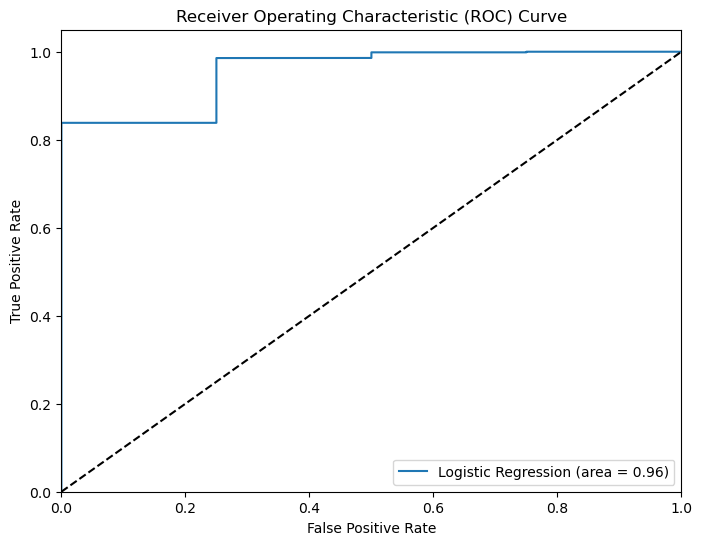

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Build the logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# Example of hyperparameter tuning with Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation ROC AUC: {grid.best_score_}")

# Example of using SMOTE for handling imbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_resampled, y_resampled)
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print("Classification Report (after SMOTE):")
print(classification_report(y_test, y_pred))

# Compare with a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"ROC AUC Score (Random Forest): {roc_auc_rf}")


Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best cross-validation ROC AUC: 0.9363130015357471
Classification Report (after SMOTE):
              precision    recall  f1-score   support

           0       0.01      0.50      0.01         4
           1       1.00      0.95      0.97      5006

    accuracy                           0.95      5010
   macro avg       0.50      0.72      0.49      5010
weighted avg       1.00      0.95      0.97      5010

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00      5006

    accuracy                           1.00      5010
   macro avg       0.50      0.50      0.50      5010
weighted avg       1.00      1.00      1.00      5010

ROC AUC Score (Random Forest): 0.7437325209748302
